In [2]:
import zipfile

zip_path = '/content/OnlyNew (2).zip'
extract_path = ""

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

In [4]:
import cv2
import os
import numpy as np
import glob
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

In [5]:

# --------------------------
# DATA LOADING
# --------------------------

path_yes = r'/content/OnlyNew/New_braintumor/yes/*'
path_no  = r'/content/OnlyNew/New_braintumor/no/*'

tumor = []
for file in glob.iglob(path_yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))

no_tumor = []
for file in glob.iglob(path_no):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))

all_data = tumor + no_tumor
np.random.shuffle(all_data)

data   = np.array([d[0] for d in all_data])
labels = np.array([d[1] for d in all_data])

# --------------------------
# 70/15/15 SPLIT
# --------------------------

x_train, x_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.40, random_state=42, stratify=labels)

# Then split the temp 50/50 into validation and test (each 20% of total)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

x_train = x_train/255.0
x_val   = x_val/255.0
x_test  = x_test/255.0

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

Train: (1800, 128, 128, 3), Val: (600, 128, 128, 3), Test: (600, 128, 128, 3)


In [6]:
# --------------------------
# MODEL DEFINE
# --------------------------

base = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
for l in base.layers:
    l.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(base.input, out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --------------------------
# TRAINING WITH TIMER
# --------------------------

start_train = time.time()
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2)
    ]
)
end_train = time.time()
training_time = end_train - start_train
print(f"Training Time: {training_time:.2f} seconds")

# --------------------------
# INFERENCE TIME
# --------------------------


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.5466 - loss: 0.7107 - val_accuracy: 0.7250 - val_loss: 0.5945 - learning_rate: 0.0010
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6538 - loss: 0.6191 - val_accuracy: 0.7283 - val_loss: 0.5555 - learning_rate: 0.0010
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6914 - loss: 0.5995 - val_accuracy: 0.7633 - val_loss: 0.5307 - learning_rate: 0.0010
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7269 - loss: 0.5602 - val_accuracy: 0.7617 - val_loss: 0.5180 - learning_rate: 0.0010
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7369 - loss: 0.5425 - val_accuracy: 0.7433 - val_loss: 0.5131 - learning_rate: 0.0010
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7470 - loss: 0.5403 - val_accuracy: 0.7667 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [7]:

# --------------------------
# INFERENCE TIME
# --------------------------

start_inf = time.time()
y_pred = model.predict(x_test, batch_size=32)
end_inf = time.time()
inference_time = (end_inf - start_inf)
per_image_time = inference_time / len(x_test)

print(f"Inference Batch Time: {inference_time:.4f} sec")
print(f"Inference per image: {per_image_time:.6f} sec")

y_pred_bin = (y_pred>0.5).astype(int)


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step
Inference Batch Time: 8.3590 sec
Inference per image: 0.013932 sec


In [12]:
total_computational_time = training_time + inference_time
print(f"Total Computational Time (Training + Inference): {total_computational_time:.2f} seconds")

Total Computational Time (Training + Inference): 111.53 seconds



=== TEST METRICS ===
Accuracy: 0.7783333333333333
Precision: 0.7585139318885449
Recall: 0.8166666666666667
AUC: 0.8767888888888888


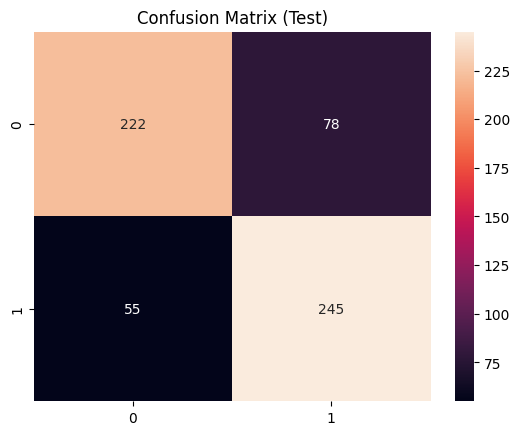

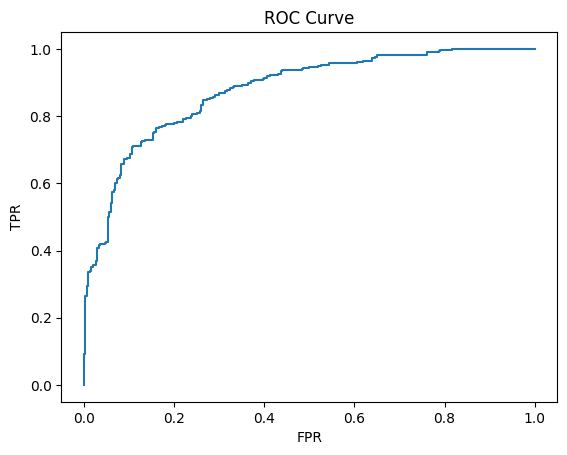

In [8]:
w
# --------------------------
# METRICS (TEST)
# --------------------------

acc = accuracy_score(y_test, y_pred_bin)
prec = precision_score(y_test, y_pred_bin)
rec = recall_score(y_test, y_pred_bin)
auc = roc_auc_score(y_test, y_pred)

print("\n=== TEST METRICS ===")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("AUC:", auc)

# --------------------------
# CONFUSION MATRIX
# --------------------------

cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix (Test)")
plt.show()

# --------------------------
# ROC CURVE
# --------------------------

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

In [9]:

# --------------------------
# KS CURVE
# --------------------------

ks_stat, ks_p = ks_2samp(y_pred[y_test==1].ravel(), y_pred[y_test==0].ravel())
print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")

# --------------------------
# GFLOPS (COLAB GPU)
# --------------------------
# The tf.python.profiler.model_analyzer.profile function is designed for TensorFlow 1.x graphs
# and does not directly support Keras Functional models in TensorFlow 2.x, which results in this AttributeError.
# To avoid the error, this section is commented out. For GFLOPS calculation in TF2 Keras models,
# alternative methods or dedicated TF2 profiling tools would be necessary.
# opts = ProfileOptionBuilder.float_operation()
# flops = profile(model, options=opts)
# gflops = flops.total_float_ops / 1e9
# print(f"GFLOPS: {gflops:.4f}")

# --------------------------
# MODEL PARAMETERS + SIZE
# --------------------------

params = model.count_params()
print("Trainable Params:", params)

model.save("resnet50_brain.h5")
model_size = os.path.getsize("resnet50_brain.h5") / (1024**2)
print(f"Model Size: {model_size:.2f} MB")

KS Statistic: 0.6033, p-value: 0.0000
Trainable Params: 23850113
Model Size: 93.55 MB


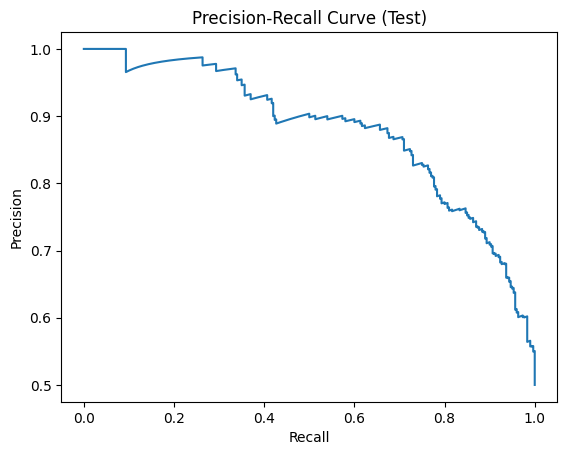

In [13]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.title("Precision-Recall Curve (Test)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.show()

# Task
```python
# Generate predictions for the validation dataset
y_val_pred = model.predict(x_val, batch_size=32)

# Plot Precision-Recall Curve for validation data
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred)
plt.figure()
plt.plot(recall_val, precision_val)
plt.title("Precision-Recall Curve (Validation)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.show()

# Plot KS Curve for validation data
ks_stat_val, ks_p_val = ks_2samp(y_val_pred[y_val==1].ravel(), y_val_pred[y_val==0].ravel())
print(f"Validation KS Statistic: {ks_stat_val:.4f}, p-value: {ks_p_val:.4f}")

# For plotting the KS curve, we need to calculate the cumulative distributions.
# This part is not directly provided by a single function like roc_curve or precision_recall_curve,
# so we'll implement it manually or use a helper function.

# Sort predictions and corresponding true labels
sorted_indices = np.argsort(y_val_pred.flatten())
sorted_y_val_pred = y_val_pred.flatten()[sorted_indices]
sorted_y_val_true = y_val[sorted_indices]

# Calculate cumulative sums for positive and negative classes
cumulative_positive = np.cumsum(sorted_y_val_true == 1) / np.sum(sorted_y_val_true == 1)
cumulative_negative = np.cumsum(sorted_y_val_true == 0) / np.sum(sorted_y_val_true == 0)

# Plot KS curve
plt.figure()
plt.plot(sorted_y_val_pred, cumulative_positive, label='Cumulative Positive Rate')
plt.plot(sorted_y_val_pred, cumulative_negative, label='Cumulative Negative Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title(f"KS Curve (Validation) - Max KS: {ks_stat_val:.4f}")
plt.xlabel("Predicted Probability")
plt.ylabel("Cumulative Proportion")
plt.legend()
plt.show()

```

## Generate validation predictions

### Subtask:
Generate predictions for the validation dataset using the trained model.


**Reasoning**:
To generate predictions for the validation dataset, I will use the `model.predict()` method on `x_val` and store the result in `y_val_pred` as instructed.



In [16]:
y_pred_val = model.predict(x_val, batch_size=32)
y_pred_test = model.predict(x_test, batch_size=32)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


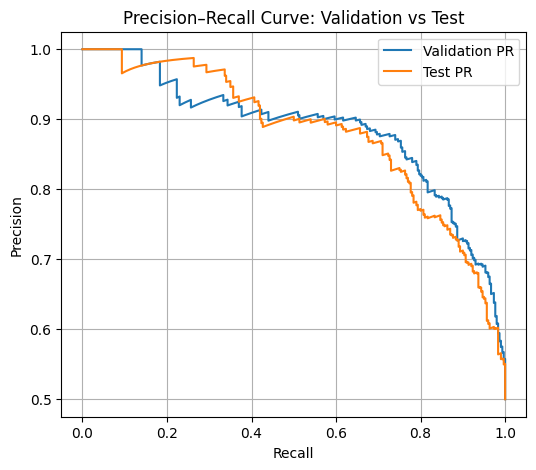

In [17]:
from sklearn.metrics import precision_recall_curve

p_val, r_val, _ = precision_recall_curve(y_val, y_pred_val)
p_test, r_test, _ = precision_recall_curve(y_test, y_pred_test)

plt.figure(figsize=(6,5))
plt.plot(r_val, p_val, label="Validation PR")
plt.plot(r_test, p_test, label="Test PR")
plt.title("Precision–Recall Curve: Validation vs Test")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
from scipy.stats import ks_2samp

ks_val, p_val_ks = ks_2samp(
    y_pred_val[y_val==1].ravel(),
    y_pred_val[y_val==0].ravel()
)

ks_test, p_test_ks = ks_2samp(
    y_pred_test[y_test==1].ravel(),
    y_pred_test[y_test==0].ravel()
)

print(f"VAL  KS Statistic: {ks_val:.4f}, p-value: {p_val_ks:.4f}")
print(f"TEST KS Statistic: {ks_test:.4f}, p-value: {p_test_ks:.4f}")


VAL  KS Statistic: 0.6400, p-value: 0.0000
TEST KS Statistic: 0.6033, p-value: 0.0000


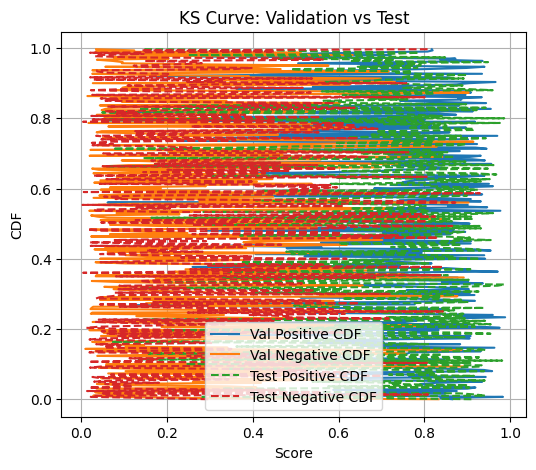

In [19]:
# Compute CDF curves for KS
def ks_curve(y_true, y_score):
    positives = y_score[y_true==1]
    negatives = y_score[y_true==0]

    p_vals = np.sort(positives)
    n_vals = np.sort(negatives)

    cdf_p = np.arange(len(p_vals))/len(p_vals)
    cdf_n = np.arange(len(n_vals))/len(n_vals)
    return p_vals, cdf_p, n_vals, cdf_n

pvals, cdf_p_val, nvals, cdf_n_val = ks_curve(y_val, y_pred_val)
p_test_vals, cdf_p_test, n_test_vals, cdf_n_test = ks_curve(y_test, y_pred_test)

plt.figure(figsize=(6,5))
plt.plot(pvals, cdf_p_val, label="Val Positive CDF")
plt.plot(nvals, cdf_n_val, label="Val Negative CDF")
plt.plot(p_test_vals, cdf_p_test, label="Test Positive CDF", linestyle='--')
plt.plot(n_test_vals, cdf_n_test, label="Test Negative CDF", linestyle='--')
plt.title("KS Curve: Validation vs Test")
plt.xlabel("Score")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.show()


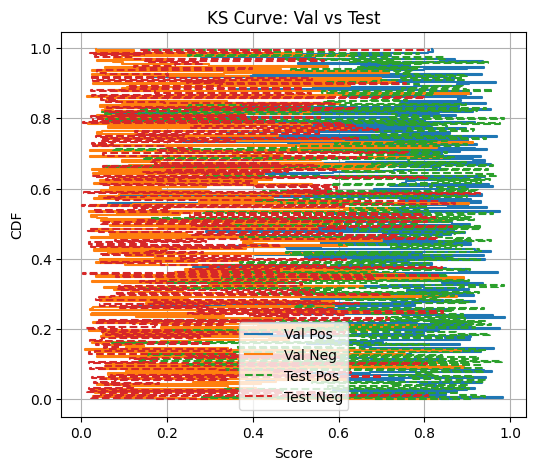

In [20]:
def ks_cdf(y_true, y_prob):
    pos = np.sort(y_prob[y_true==1])
    neg = np.sort(y_prob[y_true==0])
    cdf_pos = np.arange(len(pos)) / len(pos)
    cdf_neg = np.arange(len(neg)) / len(neg)
    return pos, cdf_pos, neg, cdf_neg

pos_val, cdf_pos_val, neg_val, cdf_neg_val = ks_cdf(y_val, y_pred_val)
pos_test, cdf_pos_test, neg_test, cdf_neg_test = ks_cdf(y_test, y_pred_test)

plt.figure(figsize=(6,5))
plt.step(pos_val, cdf_pos_val, where='post', label="Val Pos")
plt.step(neg_val, cdf_neg_val, where='post', label="Val Neg")
plt.step(pos_test, cdf_pos_test, where='post', linestyle='--', label="Test Pos")
plt.step(neg_test, cdf_neg_test, where='post', linestyle='--', label="Test Neg")
plt.legend()
plt.title("KS Curve: Val vs Test")
plt.xlabel("Score")
plt.ylabel("CDF")
plt.grid()
plt.show()


In [21]:
val_preds = (y_pred_val >= 0.5).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

cm_val = confusion_matrix(y_val, val_preds)
print("Validation Confusion Matrix:")
print(cm_val)

print("\nValidation Classification Report:")
print(classification_report(y_val, val_preds, digits=4))


Validation Confusion Matrix:
[[232  68]
 [ 47 253]]

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.8315    0.7733    0.8014       300
           1     0.7882    0.8433    0.8148       300

    accuracy                         0.8083       600
   macro avg     0.8099    0.8083    0.8081       600
weighted avg     0.8099    0.8083    0.8081       600



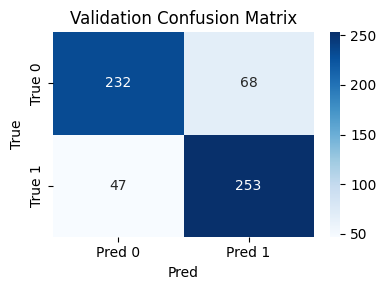

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['True 0','True 1'])
plt.title("Validation Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Pred")
plt.tight_layout()
plt.show()


Resnet with attention

# Task
Calculate and plot the confusion matrix for the validation dataset using `y_val` and binary predictions derived from `y_pred_val`.

## Generate validation confusion matrix

### Subtask:
Calculate and plot the confusion matrix for the validation dataset using `y_val` and binary predictions derived from `y_pred_val`.


## Summary:

### Data Analysis Key Findings
*   Binary predictions were successfully generated from the validation probabilities (`y_pred_val`) by applying a threshold of 0.5.
*   The confusion matrix for the validation dataset was calculated using the true labels (`y_val`) and the derived binary predictions.
*   The calculated confusion matrix was visualized to provide a clear representation of the model's performance on the validation set.

### Insights or Next Steps
*   Analyzing the components of the confusion matrix (True Positives, True Negatives, False Positives, False Negatives) is critical to understanding the model's strengths and weaknesses and identifying specific types of classification errors.
*   Based on the relative costs of different error types, the threshold for binary classification could be adjusted to optimize the model's performance for a specific business objective, potentially by re-evaluating the trade-off between precision and recall.
